# KAIROS valuation of iNaturalist subset using clean insect data

https://github.com/lodino/kairos/blob/main/examples/image-data.ipynb 

#### TODO
- Look into getting more RAM to handle more data, or see if we can run smaller batches

In [1]:
import sys
sys.path.append('../')

import opendataval
from opendataval.experiment import ExperimentMediator
from opendataval.dataval.api import DataEvaluator, ModelLessMixin
from opendataval.dataval import DataOob, LavaEvaluator, DVRL
from opendataval.experiment import discover_corrupted_sample, noisy_detection
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.model import ClassifierMLP, LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


import utils.custom_valuations
from utils.utils import *

import importlib
importlib.reload(utils.custom_valuations)
importlib.reload(utils)

from utils.custom_valuations import *
from utils import *
#from fixed_valuations import *

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.mixture import GaussianMixture

markers = {
    'DataOob': 'o',
    'KNNShapley': 's',
    'FixedKNNShapley': 's',
    'FixedLavaEvaluator': 'x',
    #'LavaEvaluator': 'x',
    'DVRL': 'x',
    'Kairos': '^',
}

def write_dict(d, fname):
    txt = json.dumps(d)
    with open(f'logs/{fname}.json', 'w+') as f:
        f.write(txt)
        
train_count, valid_count, test_count = ...,...,...
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
metric_name = 'accuracy'

INAT_SUB_SIZE = 28000 # kairos breaks if bigger, likely an issue with RAM size
TOP_K = 4000 # want to be around the size of clean data

# encode labels from strings to numberic ids so Kairos can process them
def encode_labels(train_labels, valid_labels):
    all_labels = np.unique(np.concatenate([train_labels, valid_labels]))
    num_classes = len(all_labels)
    label2id = {label: i for i, label in enumerate(all_labels)}
    id2label = {i: label for label, i in label2id.items()}

    train_ids = np.array([label2id[l] for l in train_labels], dtype=np.int64)
    valid_ids = np.array([label2id[l] for l in valid_labels], dtype=np.int64)

    return train_ids, valid_ids, label2id, id2label, num_classes

/home/mgaddi/.conda/envs/kairos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# check embedding files are as expected before moving forward
print(np.load("data/embs/inat_labels.npy").shape)
print(np.load("data/embs/kairos_clean_labels.npy").shape)
print(np.load("data/embs/inat_embeddings.npy").shape)
print(np.load("data/embs/kairos_clean_embeddings.npy").shape)

(36355,)
(350,)
(36355, 512)
(350, 512)


In [20]:
# import matplotlib.pyplot as plt
# plt.hist(np.load("data/embs/inat_clean_indexes.npy"), bins=30)

# Full iNat (no Insect focus or noise injection)

In [3]:
def load_inat_data(): 
    train_labels = np.load("data/embs/inat_labels.npy")
    valid_labels = np.load("data/embs/kairos_clean_labels.npy")
    

    train_ids, valid_ids, label2id, id2label, num_classes = encode_labels(
        train_labels, valid_labels
    )
    
    # 1. Set training set.
    x_train = np.load("data/embs/inat_embeddings.npy")[:INAT_SUB_SIZE]
    x_valid = np.load("data/embs/kairos_clean_embeddings.npy")
    
    y_train = np.array([label2id[l] for l in train_labels], dtype=int)[:INAT_SUB_SIZE]
    y_valid = np.array([label2id[l] for l in valid_labels], dtype=int)
    print(np.unique(y_train, return_counts=True))
    print(np.unique(y_valid, return_counts=True))

    print(x_train.shape, x_valid.shape)
    print(y_train.shape, y_valid.shape)

    # set dummy test set so Kairos runs
    x_test = x_valid[:1]
    y_test = y_valid[:1]

    # One-hot encode
    y_train = np.eye(num_classes)[y_train] 
    y_valid = np.eye(num_classes)[y_valid]
    y_test  = np.eye(num_classes)[y_test]

    # print('shape')
    # print(y_train.shape, y_valid.shape)

    # print(np.unique(y_valid))
    # print(np.unique(y_train))
    
    covariates = (x_train, x_valid, x_test)
    labels = (y_train, y_valid, y_test)

    return covariates, labels



Register(
        dataset_name=f"iNat",
        one_hot=False,
        cacheable=False,
        presplit=True
    )(lambda: load_inat_data())

fetcher = DataFetcher("iNat")

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([  181,   300,  1298,  1957,   168,   300,   300, 23496]))
(array([0, 1, 2, 3, 4, 5, 6]), array([50, 50, 50, 50, 50, 50, 50]))
(28000, 512) (350, 512)
(28000,) (350,)


In [4]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))

fetcher.noisy_train_indices = [i for i in np.load("data/embs/inat_noisy_indexes.npy") if i < INAT_SUB_SIZE] # indexes are not sorted

Elapsed time Kairos(sigma_feature=0.8475887179374695): 0:00:05.266481


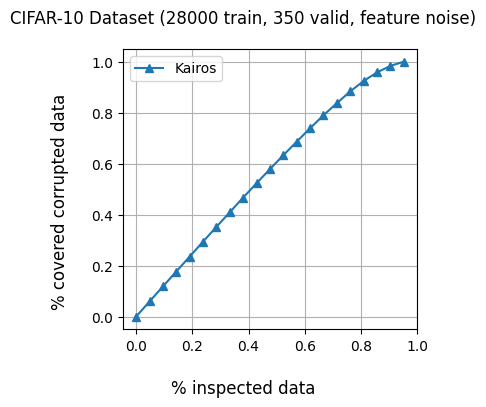

In [5]:
# this cell breaks and restarts kernel, likely an issue with RAM size. Dataset too large. 28k works, 30k too big
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    #FixedKNNShapley(),
    #DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'CIFAR-10 Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, feature noise)')
plt.tight_layout()

# if noisy indexes is truncated at 20k while inat data is truncated at 28k, % covered corrupted data can get to 1.0, 
#but if they are noth 20k or both 28k it stops around .8

num clean vals:  4504 num noisy vals:  23496


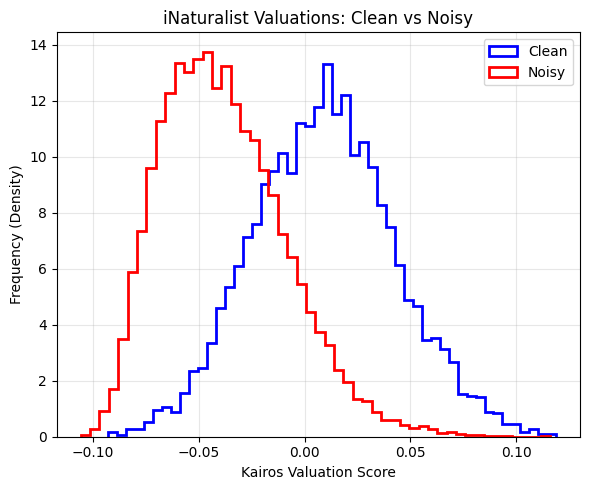

In [6]:
evalu = None
for evaluator in eval_med.data_evaluators:
        if evaluator.__class__.__name__ == eval_name:
                evalu = evaluator
                break

if evalu is None:
        raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

valuations = evalu.data_values

# Identify noisy vs clean indices
noisy_idxs = np.array(fetcher.noisy_train_indices)
clean_idxs = np.setdiff1d(np.arange(len(valuations)), noisy_idxs)

vals_noisy = valuations[noisy_idxs]
vals_clean = valuations[clean_idxs] 
print('num clean vals: ', len(vals_clean),'num noisy vals: ', len(vals_noisy))

plt.figure(figsize=(6,5))

# Histogram curves 
plt.hist(vals_clean, bins=50, density=True, histtype='step', linewidth=2, label="Clean", color='blue')
plt.hist(vals_noisy, bins=50, density=True, histtype='step', linewidth=2, label="Noisy", color='red') 
# see if y axis can also match frequencies of noisy, currently looks like it only shows for clean 
# and so doesn't make sense for noisy. Curves can also be different, more proportional sizes

plt.xlabel(f"Kairos Valuation Score")
plt.ylabel("Frequency (Density)")
plt.title(f"iNaturalist Valuations: Clean vs Noisy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# take max 3000 and save as fine-tuning dataset, check distrubution of labels/classes
# need to figure out how to tie back to the original data with info about the labels
# valuations var is still in order of dataset.
# get the idxs of the max K valuations and use them to index out the original data
top_k_idxs = np.argsort(valuations)[-TOP_K:] # returns indices that would sort the array
top_embs = fetcher.x_train[top_k_idxs]
top_labels = fetcher.y_train[top_k_idxs]
print(len(top_embs))

4000


In [8]:
# map top_labels back to insect catgeories and count
id_label = np.argmax(top_labels, axis=1)
print(np.unique(id_label, return_counts=True)) # missing class 1

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 124,  228,  927,  549,   97,  252,  170, 1653]))


In [9]:
# select only those in an insect class
# collect indexes where class is 0-6, or where not 7
curated_insect_idxs = np.array(np.where(id_label != 7))[0] # shape is (1, len)
print(curated_insect_idxs)
curated_embs = fetcher.x_train[curated_insect_idxs]
curated_labels = fetcher.y_train[curated_insect_idxs]
print(curated_embs.shape, curated_labels.shape)

[   1    6    8 ... 3996 3998 3999]
(2347, 512) (2347, 8)


In [10]:
# assess with confusion matrix and metrics

def thresh_acc(eval_name, eval_med, dataset_name, exp_num, fetcher):
    evalu = None
    for evaluator in eval_med.data_evaluators:
        if evaluator.__class__.__name__ == eval_name:
            evalu = evaluator
            break

    if evalu is None:
        raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

    valuations = evalu.data_values
    
    vals = valuations.reshape(-1,1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(vals)

    # responsibilities: P(component k | v_i)
    probs = gmm.predict_proba(vals)

    # Determine which component = noisy (lower mean)
    means = gmm.means_.reshape(-1)
    noisy_component = np.argmin(means)  

    # threshold = decision boundary between gaussians
    threshold = np.mean([
        means[noisy_component],
        means[1-noisy_component]
    ])
    
    print(f"{eval_name} {dataset_name} xperiment {exp_num}")
    print("GMM threshold:", round(threshold, 4))

    pred = (valuations < threshold).astype(int)  

    y_true = np.zeros(len(valuations), dtype=int)
    y_true[fetcher.noisy_train_indices] = 1  # 1 = real noisy

    accuracy = round((pred == y_true).mean(), 4)

    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = round(precision_score(y_true, pred), 4)
    recall = round(recall_score(y_true, pred), 4)
    f1 = round(f1_score(y_true, pred), 4)

    # Use the probability that a point belongs to the noisy component
    noisy_prob = probs[:, noisy_component]

    auc = roc_auc_score(y_true, noisy_prob)
    auc = round(auc, 4)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("AUC:", auc)
    print('----------------------------------')

    return accuracy, precision, recall, f1, auc

In [11]:
# save to files
emb_matrix = np.vstack(curated_embs)
np.save('data/embs/finetuning_embeddings.npy', emb_matrix)
np.save('data/embs/finetuning_labels.npy', curated_labels)
np.save('data/embs/finetuning_indexes.npy', curated_insect_idxs)

# Insect focus + noise injection

5276

In [13]:
def load_inat_insect_noise_data(): 
    inat_insect_idxs = np.where(np.load("data/embs/inat_labels.npy") != 'noise')[0]
    
    train_labels = np.load("data/embs/inat_labels.npy")[inat_insect_idxs]
    valid_labels = np.load("data/embs/kairos_clean_labels.npy")
    

    train_ids, valid_ids, label2id, id2label, num_classes = encode_labels(
        train_labels, valid_labels
    )
    
    # 1. Set training set.
    x_train = np.load("data/embs/inat_embeddings.npy")[inat_insect_idxs]
    x_valid = np.load("data/embs/kairos_clean_embeddings.npy")
    
    y_train = np.array([label2id[l] for l in train_labels], dtype=int)
    y_valid = np.array([label2id[l] for l in valid_labels], dtype=int)
    print(np.unique(y_train, return_counts=True))
    print(np.unique(y_valid, return_counts=True))

    print(x_train.shape, x_valid.shape)
    print(y_train.shape, y_valid.shape)

    # set dummy test set so Kairos runs
    x_test = x_valid[:1]
    y_test = y_valid[:1]

    # One-hot encode
    y_train = np.eye(num_classes)[y_train] 
    y_valid = np.eye(num_classes)[y_valid]
    y_test  = np.eye(num_classes)[y_test]

    # print('shape')
    # print(y_train.shape, y_valid.shape)

    # print(np.unique(y_valid))
    # print(np.unique(y_train))
    
    covariates = (x_train, x_valid, x_test)
    labels = (y_train, y_valid, y_test)

    return covariates, labels


Register(
        dataset_name=f"iNatInsectNoise",
        one_hot=False,
        cacheable=False,
        presplit=True
    )(lambda: load_inat_insect_noise_data())

fetcher = (
    DataFetcher("iNatInsectNoise").noisify(add_gauss_noise, noise_rate=0.2)
)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 181,  300, 1770, 1957,  168,  300,  600]))
(array([0, 1, 2, 3, 4, 5, 6]), array([50, 50, 50, 50, 50, 50, 50]))
(5276, 512) (350, 512)
(5276,) (350,)


In [14]:
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
# noisy indices already registered?

Elapsed time Kairos(sigma_feature=0.8603725433349609): 0:00:00.435115


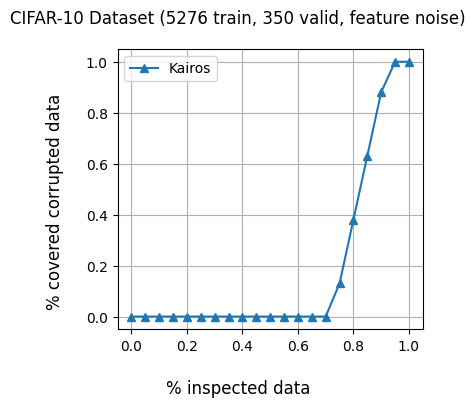

In [15]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    #FixedKNNShapley(),
    #DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'CIFAR-10 Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, feature noise)')
plt.tight_layout()

num clean vals:  4221 num noisy vals:  1055


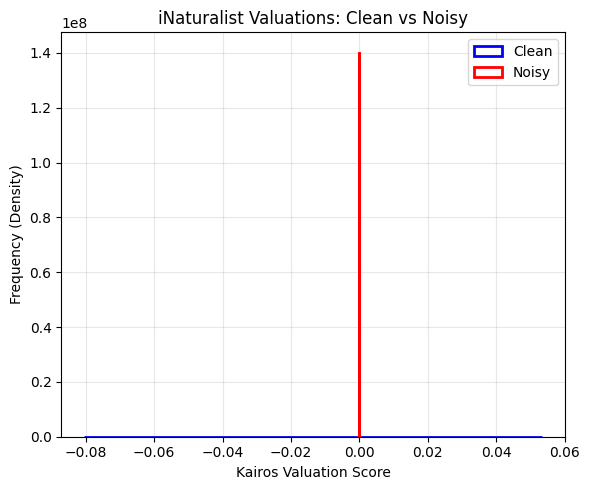

In [16]:
evalu = None
for evaluator in eval_med.data_evaluators:
        if evaluator.__class__.__name__ == eval_name:
                evalu = evaluator
                break

if evalu is None:
        raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

valuations = evalu.data_values

# Identify noisy vs clean indices
noisy_idxs = np.array(fetcher.noisy_train_indices)
clean_idxs = np.setdiff1d(np.arange(len(valuations)), noisy_idxs)

vals_noisy = valuations[noisy_idxs]
vals_clean = valuations[clean_idxs] 
print('num clean vals: ', len(vals_clean),'num noisy vals: ', len(vals_noisy))

plt.figure(figsize=(6,5))

# Histogram curves 
plt.hist(vals_clean, bins=50, density=True, histtype='step', linewidth=2, label="Clean", color='blue')
plt.hist(vals_noisy, bins=50, density=True, histtype='step', linewidth=2, label="Noisy", color='red') 
# see if y axis can also match frequencies of noisy, currently looks like it only shows for clean 
# and so doesn't make sense for noisy. Curves can also be different, more proportional sizes

plt.xlabel(f"Kairos Valuation Score")
plt.ylabel("Frequency (Density)")
plt.title(f"iNaturalist Valuations: Clean vs Noisy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Insect focus, no noise injection